In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

LABEL = "160_labelled"

# initializing lemmatizer
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wordnet_lemmatizer.lemmatize)
 
# ===========helper methods ========================================
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

def stop_words_list():
    """
        A stop list specific to the observed timelines composed of noisy words
        This list would change for different set of timelines
    """
    stop_words = ['bc', 'http', 'https', 'co', 'rt', 'one', 'us', 'new',
              'lol', 'may', 'get', 'want', 'like', 'love', 'no', 'thank', 'would', 'thanks',
              'via', 'today', 'gt', 'great', 'watch', 'watched', 'season',
              '00p']

    stoplist  = set( nltk.corpus.stopwords.words("english") + stop_words)
    return stoplist

def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

def tokenize(text):
    """
    helper function to readTweets() removes url and tokenizes text
    :param text
    """
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = re.sub(r"""[\'\"]""",'', text)
    regexps = (
        r"""(?:[\w_]+)""",                          # regular word
        r"""(?:[a-z][a-z'\-_]+[a-z])"""             # word with an apostrophe or a dash
    )
    tokens_regexp = re.compile(r"""(%s)""" % "|".join(regexps),
                               re.VERBOSE | re.I | re.UNICODE)
    return tokens_regexp.findall(text)

def replace_acronym(tokens, slang_dict):
    new_tokens = []
    for token in tokens:
        if token in slang_dict:
            new_tokens.extend(slang_dict[token].split())
        else:
            new_tokens.append(token)
    return new_tokens

def tokenize_and_lemmatize(text, slang_dict, stop_words):
    # get the tokens, lowercase - replace acronym
    lowered = [item.lower() for item in tokenize(text)]
    tokens = replace_acronym(lowered, slang_dict)

    
    tokens_pos = pos_tag(tokens)
    words = []
    for token in tokens_pos:
        pos = get_wordnet_pos(token[1])
        # if verb, noun, adj or adverb include them after lemmatization
        if pos is not None and token[0] not in stop_words:
            try:
                tok = lemmatize(token[0], pos)
                words.append(tok)
            except UnicodeDecodeError:
                pass
    # print words
    return words

def read_in_dict(filename):
    dict = {}
    with open(filename) as f:
        for line in f.readlines():
            parts = line.partition(":")
            dict[parts[0].strip()] = parts[2].strip()
    return dict

In [2]:
test_df = pd.read_csv("data/cluster_test.csv",  low_memory=False)

<hr>
### <u>About the Dataset </u>
Reading the data set, This dataset has 160 tweets , with labels 
<hr>

In [3]:
print(test_df[:5])

   Unnamed: 0      label                                              tweet  \
0           0  #politics  Delano Hotel Sold to Company That Runs SLS, Ra...   
1           1  #politics  Who Promoted #PrivateRyan? | RealClearPolitics...   
2           2  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
3           3  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
4           4  #politics  Lead testing inconsistent in Washington school...   

                 user  
0  730076605708537856  
1  730076585378893824  
2  730076554542391296  
3  730076553850269696  
4  730076487123017728  


In [4]:
# convert the pandas series (tweet text) to numpy array
text = test_df.iloc[:, 2]
tweet_text = np.array(text)

Take the column of tweet text and convert to numpy array, for use in tfidf

In [5]:
def get_tfidf_model(texts, stop_words= None, slang_dict=None):
    stop_words = stop_words_list()
    vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 )

    #print ("vocabulary_: ", vectorizer.vocabulary_)
    
    tfidf_model = vectorizer.fit_transform(texts)
    return tfidf_model, vectorizer
    

slang_dict = read_in_dict("data/out_slang_map.csv")
tfidf_model, vectorizer = get_tfidf_model(tweet_text[:1000], stop_words_list(), slang_dict)

print(tfidf_model.shape)

(160, 90)


In [6]:
# gmm maximisation
clf = mixture.GMM(n_components=10, n_iter=500, n_init=10)
print (clf)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=10, n_iter=500, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


Aikaki Information Criteria(AIC) and the Bayesian Information Criterion(BIC)

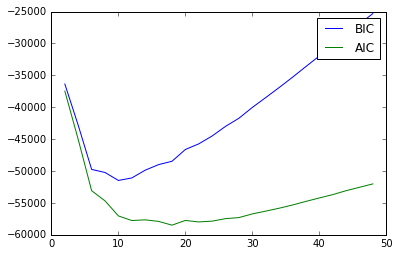

In [7]:
n_estimators = np.arange(2,50, step=2)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

n             bic              aic 
2             -36361              -37471
3             -44043              -45710
4             -47174              -49397
5             -48946              -51726
6             -50397              -53733
7             -50461              -54354
8             -51712              -56162
9             -51805              -56811
10             -51912              -57475
11             -51379              -57499


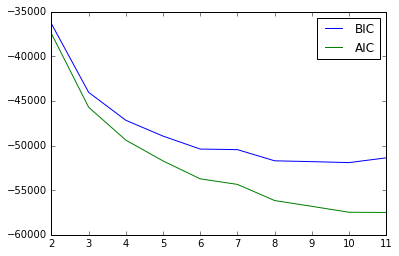

In [8]:
n_estimators = np.arange(2,12, step=1)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

i = 1
print("n             bic              aic ")
for x, y in zip(bics, aics):
    i += 1
    print("%d             %d              %d" % (i, x, y) )

In [9]:
# Log probabilities of each data point in tfarray
clf = mixture.GMM(n_components=9, n_iter=500).fit(tfarray)
print( clf.score(tfarray))


[ 187.56841126  187.56841126  176.87560436  176.87560436  183.76071692
  183.93440144  184.26370036  183.48130774  163.80126059  184.26370036
  183.73339671  184.36334544  183.79127462  163.33505506  183.5181768
  177.66287725  187.56841126  183.91976056  184.14874747  181.41925617
  198.32191254  198.19761814  194.25585628  198.19761814  198.32191254
  194.05274534  194.1576273   199.52327808  194.68824056  197.58701912
  196.0179341   188.49698799  178.10184362  185.35992365  185.35992365
  182.34774834  190.76181775  186.93047374  199.52327808  188.49698799
  174.83690525  185.62894242  171.31820464  171.31820464  160.16941853
  180.91520845  185.62894242  185.62894242  178.78470341  185.62894242
  178.26642563  175.4475332   175.34889466  180.07794358  183.94500953
  164.88053387  171.31820464  179.04732786  180.93536745  185.62894242
  191.14764757  191.13954069  197.54259143  200.1513859   198.72996299
  198.25093875  200.1513859   196.19073313  198.25093875  200.1513859
  196.16

<hr>
<b> GMM EM gives 9 clusters </b>


In [15]:
# true labels
t_labels = test_df.iloc[:, 1]

# run k means :
clusters = 9
km_model = KMeans(n_clusters=clusters)
cluster = km_model.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

print(type(cluster))
test_df.loc[:, 'cluster'] = pd.Series(cluster)
print(test_df[:5])
test_df.to_csv("results/kmeans_" + LABEL + ".csv")

Silhouette score                   : 0.233666
Adjusted Rand Score                : 0.935626
Adjusted Mutual Information Score  : 0.933459
Normalized Mutual Information Score: 0.957592
Normalized Mutual Information Score: 0.957592
Homogeniety Score                  : 0.975833
Completeness Score                 : 0.939692
<class 'numpy.ndarray'>
   Unnamed: 0      label                                              tweet  \
0           0  #politics  Delano Hotel Sold to Company That Runs SLS, Ra...   
1           1  #politics  Who Promoted #PrivateRyan? | RealClearPolitics...   
2           2  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
3           3  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
4           4  #politics  Lead testing inconsistent in Washington school...   

                 user  cluster  
0  730076605708537856        6  
1  730076585378893824        6  
2  730076554542391296        6  
3  730076553850269696        6  
4  73007648712

In [11]:
# top 10 words in a cluster
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: food recipe deal enjoy foodporn yum foodie simple roger tonight
Cluster 1: music roger aaa start live play terminal say problem sport
Cluster 2: news game gamingnews mobile phone apple lovescroll todayng release roger
Cluster 3: politics trump roger news freedom dead fuck problem washington amp
Cluster 4: fashion style womens top amp photo show kiss life terminal
Cluster 5: art roger inspire work f1 slipstream lewishamilton form mercedesamgf1 benz
Cluster 6: tv roger movie series life game free show top work
Cluster 7: sport uk record terminal open roger awesome need news tour
Cluster 8: cruz leave enter white door house race open politics reuters


In [12]:
# run Birch:
birch = Birch(n_clusters=clusters)
cluster = birch.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.178664
Adjusted Rand Score                : 0.571966
Adjusted Mutual Information Score  : 0.682479
Normalized Mutual Information Score: 0.716375
Normalized Mutual Information Score: 0.716375
Homogeniety Score                  : 0.713454
Completeness Score                 : 0.719308


In [13]:
# run SpectralClustering
spectral = SpectralClustering(n_clusters=clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
cluster = spectral.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.230888
Adjusted Rand Score                : 0.893085
Adjusted Mutual Information Score  : 0.904963
Normalized Mutual Information Score: 0.930468
Normalized Mutual Information Score: 0.930468
Homogeniety Score                  : 0.947349
Completeness Score                 : 0.913887


In [14]:
# db scan
dbscan = DBSCAN(eps=.2)
cluster = dbscan.fit_predict(tfidf_model)
print("clusters by DBSCAN: %d" % len(set(cluster)))
# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))


clusters by DBSCAN: 4
Silhouette score                   : 0.049267
Adjusted Rand Score                : 0.009247
Adjusted Mutual Information Score  : 0.063933
Normalized Mutual Information Score: 0.219022
Normalized Mutual Information Score: 0.219022
Homogeniety Score                  : 0.097742
Completeness Score                 : 0.490791
